In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import preprocessing, svm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

pd.options.display.max_columns = None

In [2]:
# Read in necessary files

# Bank data
bank_data = pd.read_csv('bank-full.csv', delimiter = ';',converters = {'day':str})

bank_data


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
# See summary statistics

summary_stats = bank_data.describe()
print(summary_stats)

                age        balance      duration      campaign         pdays  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058    258.163080      2.763841     40.197828   
std       10.618762    3044.765829    257.527812      3.098021    100.128746   
min       18.000000   -8019.000000      0.000000      1.000000     -1.000000   
25%       33.000000      72.000000    103.000000      1.000000     -1.000000   
50%       39.000000     448.000000    180.000000      2.000000     -1.000000   
75%       48.000000    1428.000000    319.000000      3.000000     -1.000000   
max       95.000000  102127.000000   4918.000000     63.000000    871.000000   

           previous  
count  45211.000000  
mean       0.580323  
std        2.303441  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


In [4]:
# See proportions for all variables

def printing_with_proportions(cols):
    for col in cols:
        proportions = bank_data[col].value_counts(normalize=True) * 100
        proportions = proportions.rename('proportion')
        print(proportions)
        print("\n")
 
printing_with_proportions(['job','marital','education','default','housing','loan','contact','poutcome'])

job
blue-collar      21.525735
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
unknown           0.637013
Name: proportion, dtype: float64


marital
married     60.193316
single      28.289576
divorced    11.517109
Name: proportion, dtype: float64


education
secondary    51.319369
tertiary     29.419831
primary      15.153392
unknown       4.107407
Name: proportion, dtype: float64


default
no     98.197341
yes     1.802659
Name: proportion, dtype: float64


housing
yes    55.583818
no     44.416182
Name: proportion, dtype: float64


loan
no     83.977351
yes    16.022649
Name: proportion, dtype: float64


contact
cellular     64.774059
unknown      28.798301
telephone     6.427639
Name: proportion, dtype: float64


poutcome
unknown    81.747805
failure    10.840282


# Distribution of Response Variable

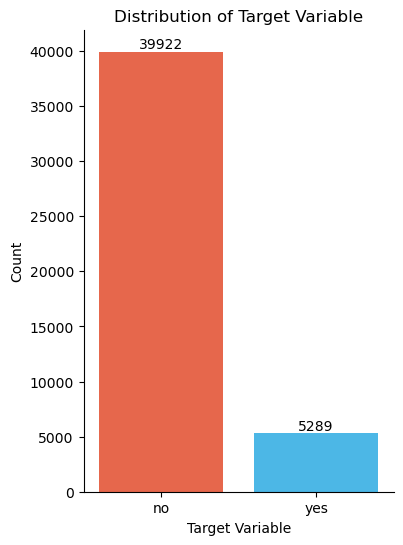

In [6]:
# Look at distribution of response variable

# Convert 'y' to a categorical variable if it's not already
bank_data['y'] = bank_data['y'].astype('category')

# Create the bar plot
plt.figure(figsize=(4, 6))
plot = sns.countplot(data=bank_data,x='y',hue='y',palette=["#FF5733", "#33C1FF"])
for i in plot.containers:
    plot.bar_label(i,)

# Set the title and labels
plt.title("Distribution of Target Variable")
plt.xlabel("Target Variable")
plt.ylabel("Count")

# Customize the grid and border
sns.despine()  # Remove top and right spines
plt.grid(False)  # Remove grid
plt.show()

## bank_data Preprocessing - Feature Exploration/Handling Unknowns

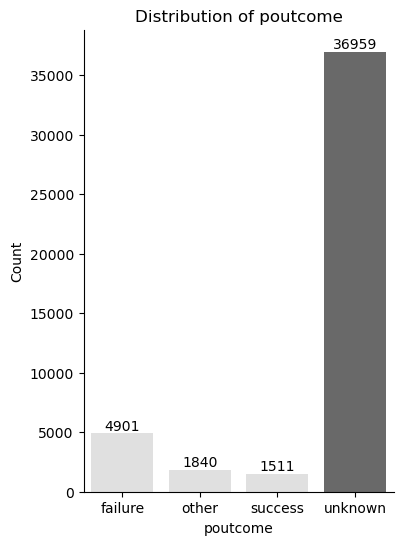

In [8]:
# Look at distribution of poutcome

# Convert 'poutcome' to a categorical variable if it's not already
bank_data['poutcome'] = bank_data['poutcome'].astype('category')

# Create color mapping
color_mapping = {'unknown': '#696969'}
for category in bank_data['poutcome'].cat.categories:
    if category != 'unknown':
        color_mapping[category] = '#E0E0E0'

# Create the bar plot
plt.figure(figsize=(4, 6))
plot = sns.countplot(data=bank_data,x='poutcome',hue='poutcome',palette=color_mapping)
for i in plot.containers:
    plot.bar_label(i,)


# Set the title and labels
plt.title("Distribution of poutcome")
plt.xlabel("poutcome")
plt.ylabel("Count")

# Customize the grid and border
sns.despine()  # Remove top and right spines
plt.grid(False)  # Remove grid
plt.show()

# Too many unknowns in poutcome to derive anything meaningful
bank_data = bank_data.drop('poutcome',axis=1)

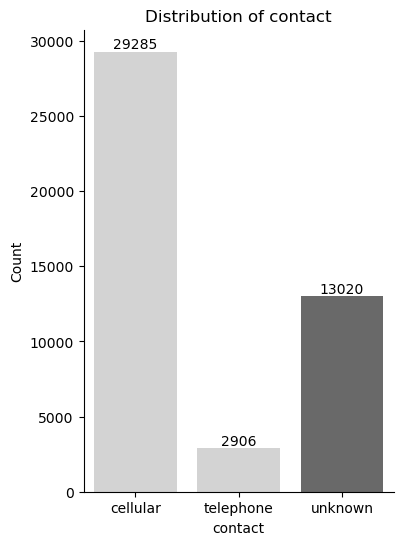

In [9]:
# Look at distribution of contact

# Convert 'poutcome' to a categorical variable if it's not already
bank_data['contact'] = bank_data['contact'].astype('category')

# Create color mapping
color_mapping = {'unknown': '#696969'}
for category in bank_data['contact'].cat.categories:
    if category != 'unknown':
        color_mapping[category] = '#D3D3D3'

# Create the bar plot
plt.figure(figsize=(4, 6))
plot = sns.countplot(data=bank_data,x='contact',hue='contact',palette=color_mapping)
for i in plot.containers:
    plot.bar_label(i,)

# Set the title and labels
plt.title("Distribution of contact")
plt.xlabel("contact")
plt.ylabel("Count")

# Customize the grid and border
sns.despine()  # Remove top and right spines
plt.grid(False)  # Remove grid
plt.show()

# Significant number of unknowns in contact and might be associated with duration which is a result of contact
# Drop contact
bank_data = bank_data.drop('contact',axis=1)

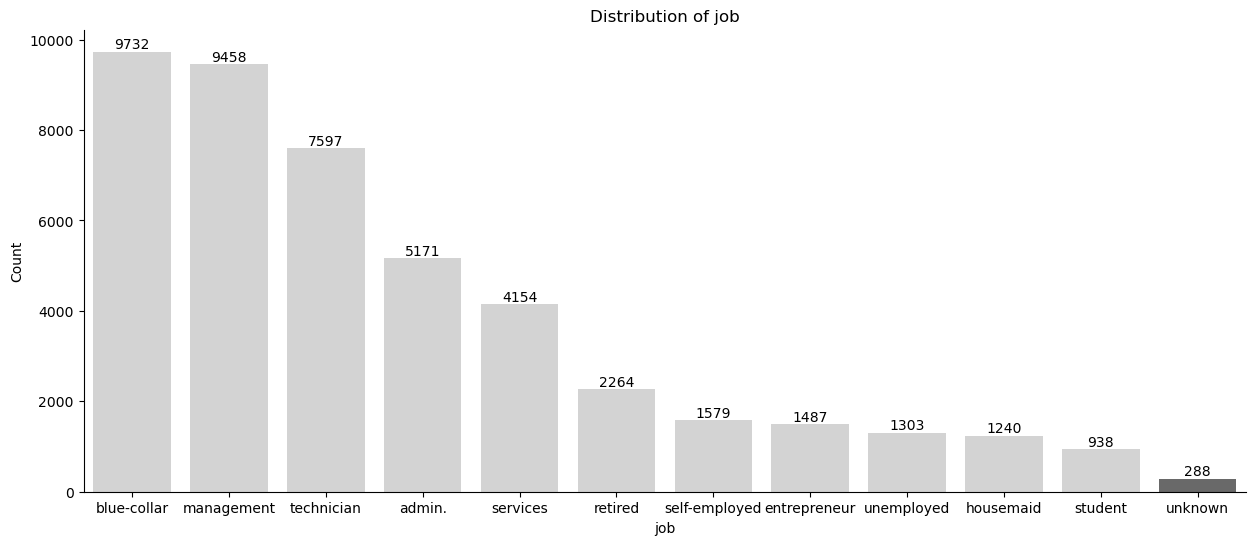

Response variable distribution is 0.1324833425179099
Unknown job distribution is 0.13385826771653545


In [10]:
# Look at distribution of job

# Convert 'poutcome' to a categorical variable if it's not already
bank_data['job'] = bank_data['job'].astype('category')

# Create color mapping
color_mapping = {'unknown': '#696969'}
for category in bank_data['job'].cat.categories:
    if category != 'unknown':
        color_mapping[category] = '#D3D3D3'

# Create the bar plot
plt.figure(figsize=(15, 6))
plot = sns.countplot(data=bank_data,x='job',hue='job',palette=color_mapping,order=bank_data['job'].value_counts().index)
for i in plot.containers:
    plot.bar_label(i,)

# Set the title and labels
plt.title("Distribution of job")
plt.xlabel("job")
plt.ylabel("Count")

# Customize the grid and border
sns.despine()  # Remove top and right spines
plt.grid(False)  # Remove grid
plt.show()

# See breakdown of response variable for unknown category for 'job'
print("Response variable distribution is " + str(bank_data['y'].value_counts().iloc[1]/bank_data['y'].value_counts().iloc[0]))

print("Unknown job distribution is " + str(bank_data[bank_data['job'] == 'unknown']['y'].value_counts().iloc[1]/bank_data[bank_data['job'] == 'unknown']['y'].value_counts().iloc[0]))

# Note the small number of unknowns with similar distribution to overall counts in response variable
# We will try to inpute unknowns for job using available data

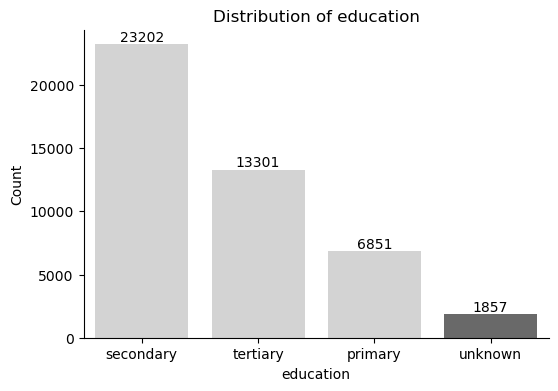

Response variable distribution is 0.1324833425179099
Unknown education distribution is 0.15700934579439252


In [11]:
# Look at distribution of education

# Convert 'poutcome' to a categorical variable if it's not already
bank_data['education'] = bank_data['education'].astype('category')

# Create color mapping
color_mapping = {'unknown': '#696969'}
for category in bank_data['education'].cat.categories:
    if category != 'unknown':
        color_mapping[category] = '#D3D3D3'

# Create the bar plot
plt.figure(figsize=(6, 4))
plot = sns.countplot(data=bank_data,x='education',hue='education',palette=color_mapping,order=bank_data['education'].value_counts().index)
for i in plot.containers:
    plot.bar_label(i,)

# Set the title and labels
plt.title("Distribution of education")
plt.xlabel("education")
plt.ylabel("Count")

# Customize the grid and border
sns.despine()  # Remove top and right spines
plt.grid(False)  # Remove grid
plt.show()

# See breakdown of response variable for unknown category for 'job'
print("Response variable distribution is " + str(bank_data['y'].value_counts().iloc[1]/bank_data['y'].value_counts().iloc[0]))

print("Unknown education distribution is " + str(bank_data[bank_data['education'] == 'unknown']['y'].value_counts().iloc[1]/bank_data[bank_data['education'] == 'unknown']['y'].value_counts().iloc[0]))

# Note the small number of unknowns with similar distribution to overall counts in response variable
# We will try to inpute unknowns for education using available data

## Boxplots for exploration

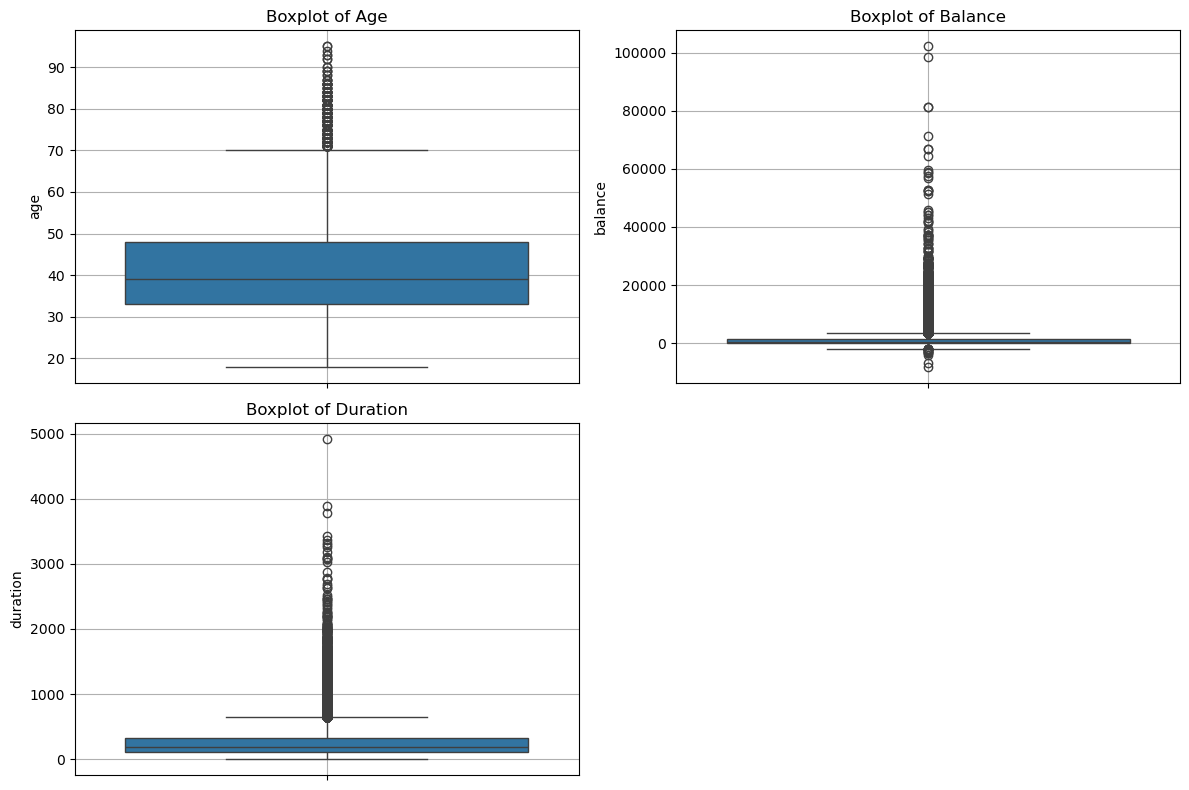

In [13]:
num_cols = bank_data[["age", "balance", "duration"]]
 
# Set up the plotting area for the boxplots
plt.figure(figsize=(12, 8))
 
# Create a boxplot for each numerical column
for i, column in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)  # 2x2 grid for the boxplots
    sns.boxplot(data=bank_data, y=column)
    plt.title(f"Boxplot of {column.capitalize()}")
    plt.grid(True)
 
# Adjust layout
plt.tight_layout()
plt.show()

## Delete unknowns for both job and education

In [15]:
# Percentage of rows with both unknowns for job and education

print("Percentage of data rows with unknowns for both job and education is" + str(len(bank_data[(bank_data['job']=='unknown') & (bank_data['education']=='unknown')])/len(bank_data)*100) + '%')

# Given the strong relationship between these features (e.g., job often influences education level and vice versa), dropping rows with missing values 
# in both job and education.

bank_data = bank_data[~((bank_data['job'] == 'unknown') & (bank_data['education'] == 'unknown'))]


Percentage of data rows with unknowns for both job and education is0.2809050894693769%


## Impute Unknowns

In [17]:
# We next try to inpute unknowns for job and education

# Replace unknown with nan
bank_data.replace('unknown', np.nan, inplace=True)
#bank_data = bank_data.dropna(subset=['job', 'education'], how='all', axis=0)
 
# Percentage of nan
nan_counts = bank_data.isna().sum(axis = 0)
percentage_nan = (nan_counts / len(bank_data)) * 100
print(percentage_nan)
 
# Convert education to numbers
le=preprocessing.LabelEncoder()
col = 'education'
col_encoded = 'edu_no'
le.fit(bank_data.loc[:,col])
dict(zip(le.classes_, le.transform(le.classes_)))
bank_data[col_encoded]=le.transform(bank_data[col])
 
# We first try to impute job with age, balance and edu_no
le=preprocessing.LabelEncoder()
impute_col = 'job'
impute_col_encoded = 'job_no'
le.fit(bank_data.loc[:,impute_col])
dict(zip(le.classes_, le.transform(le.classes_))) #run till here to see labels, nan: 11
bank_data[impute_col_encoded]=le.transform(bank_data[impute_col])
bank_data[impute_col_encoded] = bank_data[impute_col_encoded].map(lambda x: np.nan if x==11 else x)
imputer = IterativeImputer(random_state = 100)
df_train = bank_data.loc[:, ['age','balance','edu_no',impute_col_encoded]]
imputer.fit(df_train)
IterativeImputer(random_state=100)
df_imputed = imputer.transform(df_train)
df_imputed[:,3].round()
bank_data.loc[:,[impute_col_encoded]] = df_imputed[:,3].round()
job_imputed = list(le.inverse_transform(bank_data[impute_col_encoded].round().astype('int')))
bank_data['job_imputed'] = job_imputed

# Then we impute edu_no with age, balance and job_no
le=preprocessing.LabelEncoder()
impute_col = 'education'
impute_col_encoded = 'edu_no'
le.fit(bank_data.loc[:,impute_col])
dict(zip(le.classes_, le.transform(le.classes_))) #see labels nan:3
bank_data[impute_col_encoded]=le.transform(bank_data[impute_col])
bank_data[impute_col_encoded] = bank_data[impute_col_encoded].map(lambda x: np.nan if x==3 else x) #nan:3
imputer = IterativeImputer(random_state = 100)
df_train = bank_data.loc[:, ['age','balance','job_no',impute_col_encoded]]
imputer.fit(df_train)
IterativeImputer(random_state=100)
df_imputed = imputer.transform(df_train)
df_imputed[:,3].round()
bank_data.loc[:,[impute_col_encoded]] = df_imputed[:,3].round()
edu_imputed = list(le.inverse_transform(bank_data[impute_col_encoded].round().astype('int')))
bank_data['edu_imputed'] = edu_imputed

# And we drop job and education afterwards, keeping the variable with imputed unknowns
bank_data = bank_data.drop(['job','education','job_no','edu_no'],axis=1)

age          0.000000
job          0.357111
marital      0.000000
education    3.837282
default      0.000000
balance      0.000000
housing      0.000000
loan         0.000000
day          0.000000
month        0.000000
duration     0.000000
campaign     0.000000
pdays        0.000000
previous     0.000000
y            0.000000
dtype: float64


C:\Users\hojun\AppData\Local\Temp\ipykernel_16920\286789046.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  bank_data.replace('unknown', np.nan, inplace=True)


In [18]:
# Final check for any nulls
bank_data.isnull().sum(axis = 0)

# looks good

age            0
marital        0
default        0
balance        0
housing        0
loan           0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
y              0
job_imputed    0
edu_imputed    0
dtype: int64

## bank_data Preprocessing - Feature Engineering

In [20]:
# Create new category called job_education. Theory is that customers with education affects the job a person is in

bank_data['job_education'] = bank_data['job_imputed'] + '_' + bank_data['edu_imputed']

# And drop job_imputed and edu_imputed after to avoid collinearity

bank_data = bank_data.drop(['job_imputed','edu_imputed'], axis=1)

In [21]:
# Dates
# Note that the data is sorted in ascending order according to date from 2008 May to 2010 Nov. 
# Therefore, we can create a year field and generate the "day of week" for each response

# Derive "Year"
# Initialize a list for years
years = []
 
# Starting year and month index
current_year = 2008
current_month_index = 0
 
# List of months corresponding to indices
months_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 
               'dec'] * 3  # Extended for three years
 
# Loop through the DataFrame to assign the correct year
for _, row in bank_data.iterrows():
    month = row['month']
    # Check if the month index needs to be incremented
    while current_month_index < len(months_list) and months_list[current_month_index] != month:
        current_month_index += 1
        if current_month_index >= len(months_list):
            break  # Exit the loop if we've gone past the list
        if current_month_index == 12:  # Increment year when we reach the next January
            current_year += 1
        if current_month_index == 24:  # Increment year when we reach the next January
            current_year += 1    
    # Check if the current month is valid
    if current_month_index < len(months_list):
        years.append(current_year)
    else:
        # Handle case where month is not found in the list (if necessary)
        years.append(None)  # or some default value
 
# Add the year column to the DataFrame
bank_data['year'] = years

# Map month names to numbers
month_mapping = {month: idx + 1 for idx, month in enumerate(['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                                                               'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])}
bank_data['month_num'] = bank_data['month'].map(month_mapping)

# Create a date column
bank_data['date'] = pd.to_datetime(bank_data['year'].astype(str) + '-' +
                                    bank_data['month_num'].astype(str) + '-' +
                                    bank_data['day'].astype(str))

# Derive "Day of Week"
bank_data['day_of_week'] = bank_data['date'].dt.day_name()

# Display unique values of 'day_of_week'
print("Unique days of the week:")
print(bank_data['day_of_week'].unique())

# Display counts of each year
print("Year counts:")
print(bank_data['year'].value_counts())

# Drop day, month_num and date thereafter 
bank_data = bank_data.drop(['day','month_num','date'], axis=1)


Unique days of the week:
['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Year counts:
year
2008    27639
2009    14836
2010     2609
Name: count, dtype: int64


In [22]:
# With the month and year info, we bring in the portugese interest rate as a new variable
# The idea is that higher interest rates would entice more people to place money into term deposits.

interest_data = {
    'month': ['may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov'],
    'year': [2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010],
    'interest': [0.04, 0.04, 0.0425, 0.0425, 0.0425, 0.0425, 0.0325, 0.0325, 0.025, 0.02, 0.015, 0.0125, 0.0125, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
}
 
interest_df = pd.DataFrame(interest_data)

bank_data = pd.merge(bank_data, interest_df, how='left', on=['month','year'])

bank_data

,age,marital,default,balance,housing,loan,month,duration,campaign,pdays,previous,y,job_education,year,day_of_week,interest
0,58,married,no,2143,yes,no,may,261,1,-1,0,no,management_tertiary,2008,Monday,0.04
1,44,single,no,29,yes,no,may,151,1,-1,0,no,technician_secondary,2008,Monday,0.04
2,33,married,no,2,yes,yes,may,76,1,-1,0,no,entrepreneur_secondary,2008,Monday,0.04
3,47,married,no,1506,yes,no,may,92,1,-1,0,no,blue-collar_secondary,2008,Monday,0.04
4,35,married,no,231,yes,no,may,139,1,-1,0,no,management_tertiary,2008,Monday,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45079,51,married,no,825,no,no,nov,977,3,-1,0,yes,technician_tertiary,2010,Wednesday,0.01
45080,71,divorced,no,1729,no,no,nov,456,2,-1,0,yes,retired_primary,2010,Wednesday,0.01
45081,72,married,no,5715,no,no,nov,1127,5,184,3,yes,retired_secondary,2010,Wednesday,0.01
45082,57,married,no,668,no,no,nov,508,4,-1,0,no,blue-collar_secondary,2010,Wednesday,0.01


In [23]:
# We can also create a month-year variable as an additional feature

bank_data['month_year'] = bank_data['month'] + '-' + (bank_data['year'].astype(str))

# And drop job_imputed and edu_imputed after to avoid collinearity

bank_data = bank_data.drop(['month','year'], axis=1)

bank_data

,age,marital,default,balance,housing,loan,duration,campaign,pdays,previous,y,job_education,day_of_week,interest,month_year
0,58,married,no,2143,yes,no,261,1,-1,0,no,management_tertiary,Monday,0.04,may-2008
1,44,single,no,29,yes,no,151,1,-1,0,no,technician_secondary,Monday,0.04,may-2008
2,33,married,no,2,yes,yes,76,1,-1,0,no,entrepreneur_secondary,Monday,0.04,may-2008
3,47,married,no,1506,yes,no,92,1,-1,0,no,blue-collar_secondary,Monday,0.04,may-2008
4,35,married,no,231,yes,no,139,1,-1,0,no,management_tertiary,Monday,0.04,may-2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45079,51,married,no,825,no,no,977,3,-1,0,yes,technician_tertiary,Wednesday,0.01,nov-2010
45080,71,divorced,no,1729,no,no,456,2,-1,0,yes,retired_primary,Wednesday,0.01,nov-2010
45081,72,married,no,5715,no,no,1127,5,184,3,yes,retired_secondary,Wednesday,0.01,nov-2010
45082,57,married,no,668,no,no,508,4,-1,0,no,blue-collar_secondary,Wednesday,0.01,nov-2010


## Features Importance Test

In [25]:
### Separate "features" and class "y" column from bank dataset

X = bank_data.drop(columns=['y'])
y = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standard scaling for numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encoding for categorical columns
    ])

rf = RandomForestClassifier(n_estimators=100, random_state=3)

# Create a pipeline that includes SMOTE
pipeline = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Ensure features selection is only conducted on training dataset
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size = 0.20, 
        stratify = y, # Stratified sampling for the train set to have equal subgroups
        random_state = 16)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Feature importance
importances = rf.feature_importances_

num_feature_names = numerical_cols

# For one-hot encoded categorical features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine numerical and categorical feature names
all_feature_names = list(num_feature_names) + list(cat_feature_names)

# Create a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
pd.set_option('display.max_rows', 1000)
# Display the feature importances
print(feature_importance_df)


                                  Feature  Importance
2                                duration    0.270685
6                                interest    0.096678
1                                 balance    0.092715
0                                     age    0.087246
4                                   pdays    0.040430
3                                campaign    0.039992
5                                previous    0.026233
30      job_education_management_tertiary    0.012567
50                     day_of_week_Monday    0.012461
13                            housing_yes    0.012400
53                   day_of_week_Thursday    0.012278
55                  day_of_week_Wednesday    0.011799
49                     day_of_week_Friday    0.011618
54                    day_of_week_Tuesday    0.011465
12                             housing_no    0.011159
8                         marital_married    0.010877
9                          marital_single    0.009275
44     job_education_technic

In [26]:
# The above importances takes into account one hot encoded created variables. We now group categories under the same variable together

# Dictionary to map one-hot encoded features to original feature names


# Define categorical columns
categorical_columns = ['job_imputed', 'marital', 'edu_imputed', 'default', 'housing', 'loan','month', 'job_education','month_year','day_of_week']


one_hot_mapping = {
    'job_education': ['job_education_technician_secondary', 'job_education_admin._secondary', 'job_education_blue-collar_secondary',
                      'job_education_technician_tertiary', 'job_education_services_secondary', 'job_education_management_secondary',
                      'job_education_retired_secondary', 'job_education_entrepreneur_secondary', 'job_education_blue-collar_primary',
                      'job_education_admin._tertiary', 'job_education_self-employed_tertiary', 'job_education_unemployed_secondary',
                      'job_education_student_secondary', 'job_education_retired_primary', 'job_education_retired_tertiary',
                      'job_education_entrepreneur_primary', 'job_education_self-employed_secondary', 'job_education_student_tertiary',
                      'job_education_entrepreneur_tertiary', 'job_education_housemaid_primary', 'job_education_unemployed_tertiary',
                      'job_education_housemaid_secondary', 'job_education_services_primary', 'job_education_blue-collar_tertiary',
                      'job_education_housemaid_tertiary', 'job_education_management_primary', 'job_education_services_tertiary',
                      'job_education_admin._primary', 'job_education_technician_primary', 'job_education_self-employed_primary',
                      'job_education_student_primary','job_education_management_tertiary','job_education_unemployed_primary'],    
    'marital': ['marital_married', 'marital_single', 'marital_divorced'],
    'housing': ['housing_yes', 'housing_no'],
    'loan': ['loan_yes', 'loan_no'],
    'default': ['default_yes', 'default_no'],
    'day_of_week': ['day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 
                    'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday', 'day_of_week_Sunday'],
    'month_year': ['month_year_may-2008', 'month_year_jun-2008', 'month_year_jul-2008', 
                   'month_year_aug-2008', 'month_year_oct-2008', 'month_year_nov-2008', 'month_year_dec-2008', 
                   'month_year_jan-2009', 'month_year_feb-2009', 'month_year_mar-2009', 'month_year_apr-2009', 
                   'month_year_may-2009', 'month_year_jun-2009', 'month_year_jul-2009', 'month_year_aug-2009', 
                   'month_year_sep-2009', 'month_year_oct-2009', 'month_year_nov-2009', 'month_year_dec-2009', 
                   'month_year_jan-2010', 'month_year_feb-2010', 'month_year_mar-2010', 'month_year_apr-2010', 
                   'month_year_may-2010', 'month_year_jun-2010', 'month_year_jul-2010', 'month_year_aug-2010', 
                   'month_year_sep-2010', 'month_year_oct-2010', 'month_year_nov-2010']
}
# Create a DataFrame to aggregate importances
aggregated_importances = pd.DataFrame(columns=['Feature', 'Importance'])

# Loop through the mapping and aggregate importances
for original_feature, one_hot_columns in one_hot_mapping.items():
    # Sum the importances of one-hot encoded columns
    total_importance = feature_importance_df[feature_importance_df['Feature'].isin(one_hot_columns)]['Importance'].sum()
    
    # Create a DataFrame for the current row
    row = pd.DataFrame({'Feature': [original_feature], 'Importance': [total_importance]})
    
    # Concatenate the row to aggregated_importances
    aggregated_importances = pd.concat([aggregated_importances, row], ignore_index=True)

# Include original features that are not one-hot encoded
remaining_features = feature_importance_df[~feature_importance_df['Feature'].isin(sum(one_hot_mapping.values(), []))]
aggregated_importances = pd.concat([aggregated_importances, remaining_features], ignore_index=True)

# Sort the final aggregated importances
aggregated_importances = aggregated_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the aggregated importances
print(aggregated_importances)

          Feature  Importance
0        duration    0.270685
1      month_year    0.110565
2   job_education    0.109069
3        interest    0.096678
4         balance    0.092715
5             age    0.087246
6     day_of_week    0.060135
7           pdays    0.040430
8        campaign    0.039992
9         marital    0.027622
10       previous    0.026233
11        housing    0.023559
12           loan    0.012584
13        default    0.002486


C:\Users\hojun\AppData\Local\Temp\ipykernel_16920\2492798183.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_importances = pd.concat([aggregated_importances, row], ignore_index=True)


C:\Users\hojun\AppData\Local\Temp\ipykernel_16920\2939778973.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df, palette='viridis', ax=ax1)


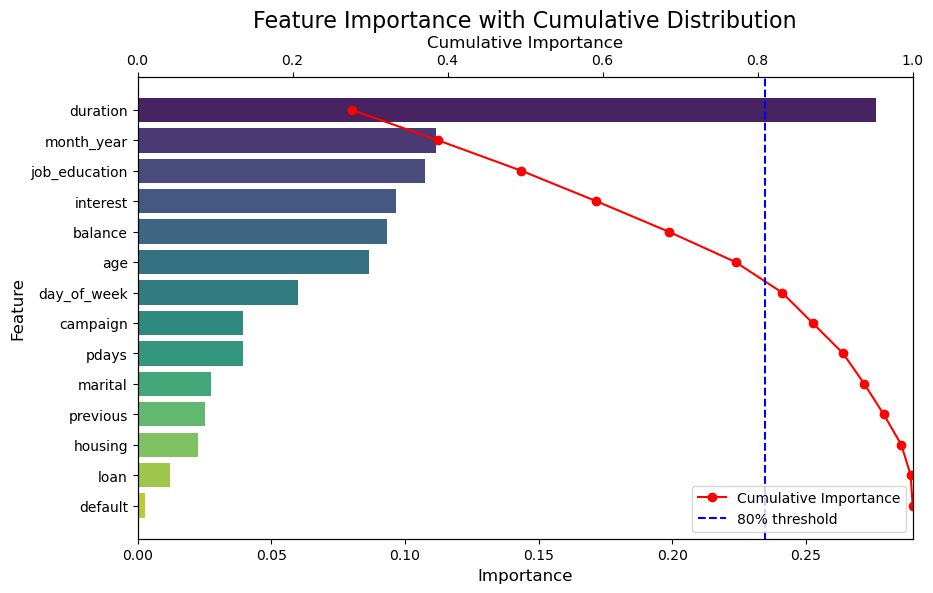

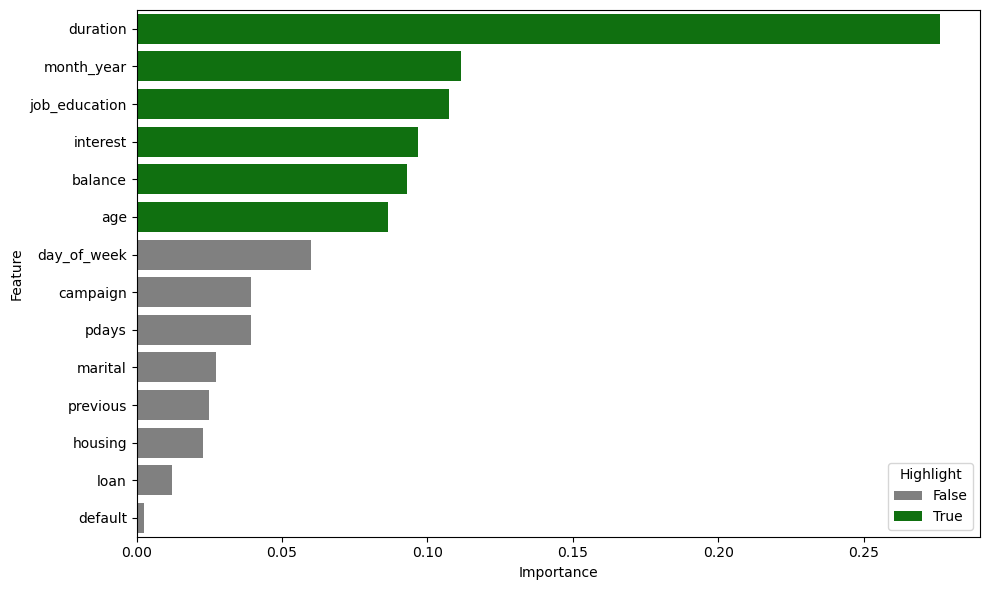

In [27]:
# Plots to better see the importance

data = {'Feature': ['duration', 'month_year','job_education','interest','balance', 'age', 
                    'day_of_week','campaign','pdays','marital', 'previous', 'housing', 'loan', 'default'],
        'Importance': [0.276189, 0.111577, 0.107408, 0.096720, 0.093123, 
                       0.086518, 0.059874, 0.039422, 0.039367, 0.027325, 
                       0.025028, 0.022768, 0.012094, 0.002586]}

df = pd.DataFrame(data)

# Sort by importance in descending order
df = df.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance
df['Cumulative_Importance'] = df['Importance'].cumsum()

# Plotting the bar plot of feature importances
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x='Importance', y='Feature', data=df, palette='viridis', ax=ax1)

# Add title and labels
ax1.set_title('Feature Importance with Cumulative Distribution', fontsize=16)
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_ylabel('Feature', fontsize=12)

# Create another axis for the cumulative importance plot
ax2 = ax1.twiny()

# Plot cumulative importance
ax2.plot(df['Cumulative_Importance'], df['Feature'], color='red', marker='o', label='Cumulative Importance')

# Add threshold for 80% (can be adjusted)
threshold = 0.81
ax2.axvline(threshold, color='blue', linestyle='--', label='80% threshold')

# Highlight features that are within the 80% cumulative importance
df['Highlight'] = df['Cumulative_Importance'] <= threshold

# Create the plot
plt.figure(figsize=(10, 6))

# Use 'Highlight' as the hue to differentiate colors
sns.barplot(x='Importance', y='Feature', data=df, hue='Highlight', dodge=False, palette={True: 'green', False: 'gray'})

# Set x-axis limits and labels for the cumulative importance
ax2.set_xlim([0, 1])
ax2.set_xlabel('Cumulative Importance', fontsize=12)

# Show legend
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Execution of Models

## Using Naive Bayes

In [30]:
# Prepare features and target
X = bank_data.drop(columns=['y'])
y = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline with preprocessing and GaussianNB
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=16)

# Parameter tuning on the training set
param_grid = {
    'classifier__var_smoothing': [1e-8, 1e-6, 1e-4, 1e-2],
    'classifier__priors': [None, [0.5, 0.5], [0.3, 0.7]]
}

# 5-fold Cross-validation using StratifiedKFold to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score on training set: ", grid_search.best_score_)

mcc_scores = []
auc_scores = []
accuracy_scores = []

final_model = grid_search.best_estimator_

# Perform cross-validation manually to get MCC, AUC, Accuracy, and Confusion Matrix for each fold
for train_index, test_index in cv.split(X, y):
    X_cv_train, X_cv_test = X.iloc[train_index], X.iloc[test_index]
    y_cv_train, y_cv_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training fold
    final_model.fit(X_cv_train, y_cv_train)
    
    # Predict on the testing fold
    y_cv_pred = final_model.predict(X_cv_test)
    y_cv_pred_proba = final_model.predict_proba(X_cv_test)[:, 1]  # Probability for the positive class

    # Compute metrics for this fold
    mcc = matthews_corrcoef(y_cv_test, y_cv_pred)
    auc = roc_auc_score(y_cv_test, y_cv_pred_proba)
    accuracy = accuracy_score(y_cv_test, y_cv_pred)
    
    mcc_scores.append(mcc)
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)

    # Compute and display confusion matrix in text format
    cm = confusion_matrix(y_cv_test, y_cv_pred)
    print(f'Confusion Matrix for this fold:\n{cm}\n')

    print(f'MCC for this fold: {mcc:.4f}, AUC: {auc:.4f}, Accuracy: {accuracy:.4f}')

# Average metrics across all folds
average_mcc = sum(mcc_scores) / len(mcc_scores)
average_auc = sum(auc_scores) / len(auc_scores)
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)

print(f'Average MCC across 5 folds: {average_mcc:.4f}')
print(f'Average AUC across 5 folds: {average_auc:.4f}')
print(f'Average Accuracy across 5 folds: {average_accuracy:.4f}')

Best parameters found:  {'classifier__priors': None, 'classifier__var_smoothing': 0.01}
Best cross-validation score on training set:  0.8659050633767569
Confusion Matrix for this fold:
[[7200  763]
 [ 457  597]]

MCC for this fold: 0.4225, AUC: 0.8377, Accuracy: 0.8647
Confusion Matrix for this fold:
[[7236  727]
 [ 449  605]]

MCC for this fold: 0.4371, AUC: 0.8338, Accuracy: 0.8696
Confusion Matrix for this fold:
[[7221  742]
 [ 467  587]]

MCC for this fold: 0.4203, AUC: 0.8368, Accuracy: 0.8659
Confusion Matrix for this fold:
[[7213  749]
 [ 471  584]]

MCC for this fold: 0.4161, AUC: 0.8464, Accuracy: 0.8647
Confusion Matrix for this fold:
[[7215  747]
 [ 438  616]]

MCC for this fold: 0.4401, AUC: 0.8395, Accuracy: 0.8686
Average MCC across 5 folds: 0.4272
Average AUC across 5 folds: 0.8389
Average Accuracy across 5 folds: 0.8667


## Using K-Nearest Neighbours

In [51]:
# Separate features (X) and target (y)
X = bank_data.drop(columns=['y'])  # Drop the target column 'y'
y = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)  # Convert target to binary (1 for 'yes', 0 for 'no')

# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standard scaling for numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encoding for categorical columns
    ])

# Define the K-Nearest Neighbors classifier
knn = KNeighborsClassifier()

# Create an imbalanced pipeline that includes SMOTEENN and the KNN classifier
pipeline = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (scaling and encoding)
    ('spos', SMOTEENN(random_state=16)),  # Handling class imbalance with SMOTEENN
    ('classifier', knn)  # KNN classifier
])

# Split the data into training (30%) and testing (70%) sets for tuning
X_train_tune, X_test_tune, y_train_tune, y_test_tune = train_test_split(X, y, test_size=0.7, random_state=16, stratify=y)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': np.arange(1, 10),  # Vary the number of neighbors between 1 and 30
    'classifier__weights': ['uniform', 'distance'],  # Test both uniform and distance-based weighting
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],  # Try different distance metrics
    'classifier__p': [1, 2]  # Minkowski distance with p=1 (Manhattan) and p=2 (Euclidean)
}

# Perform GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tune, y_train_tune)

# Best parameters from GridSearchCV
best_knn = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)
# Best hyperparameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 4, 'classifier__p': 1, 'classifier__weights': 'uniform'}

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
auc_scores = []
mcc_scores = []
confusion_matrices = []

# Variables to track the best fold based on accuracy
best_accuracy = 0
best_fold_confusion_matrix = None
best_fold_number = 0

# Initialize fold counter
fold = 1

# 5-fold Cross-validation using StratifiedKFold to maintain class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)

for train_index, test_index in skf.split(X, y):
    print(f'Fold {fold}:')

    # Split data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the best pipeline, which handles preprocessing, SMOTEENN, and fitting the model
    best_knn.fit(X_train, y_train)

    # Test the model on the test set
    y_pred = best_knn.predict(X_test)

    # Compute accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Accuracy for this fold: {accuracy:.4f}')

    # Confusion Matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    print(f'Confusion matrix for fold {fold}:\n{cm}')

    # Update the best confusion matrix if this fold has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold_confusion_matrix = cm
        best_fold_number = fold

    # AUC Score
    y_prob = best_knn.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class
    auc_score = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc_score)
    print(f'AUC Score for this fold: {auc_score:.4f}')

    # Compute MCC for this fold
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    print(f'MCC for this fold: {mcc:.4f}', "\n")

    # Increment the fold counter
    fold += 1

# Average accuracy across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f'Average accuracy across {fold-1} folds: {average_accuracy:.4f}')

# Average AUC score across all folds
average_auc = sum(auc_scores) / len(auc_scores)
print(f'Average AUC across {fold-1} folds: {average_auc:.4f}')

# Average MCC across all folds
average_mcc = sum(mcc_scores) / len(mcc_scores)
print(f'Average MCC across {fold-1} folds: {average_mcc:.4f}')

# Print the best confusion matrix and the corresponding fold number
print(f'Best confusion matrix was from fold {best_fold_number} with accuracy of {best_accuracy:.4f}:')
print(best_fold_confusion_matrix)

Best hyperparameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 4, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Fold 1:
Accuracy for this fold: 0.8888
Confusion matrix for fold 1:
[[7426  537]
 [ 466  588]]
AUC Score for this fold: 0.8537
MCC for this fold: 0.4768 

Fold 2:
Accuracy for this fold: 0.8905
Confusion matrix for fold 2:
[[7427  536]
 [ 451  603]]
AUC Score for this fold: 0.8590
MCC for this fold: 0.4882 

Fold 3:
Accuracy for this fold: 0.8841
Confusion matrix for fold 3:
[[7382  581]
 [ 464  590]]
AUC Score for this fold: 0.8566
MCC for this fold: 0.4653 

Fold 4:
Accuracy for this fold: 0.8810
Confusion matrix for fold 4:
[[7352  610]
 [ 463  592]]
AUC Score for this fold: 0.8539
MCC for this fold: 0.4582 

Fold 5:
Accuracy for this fold: 0.8889
Confusion matrix for fold 5:
[[7407  555]
 [ 447  607]]
AUC Score for this fold: 0.8593
MCC for this fold: 0.4854 

Average accuracy across 5 folds: 0.8867
Average AUC across 5 folds: 0.8565
Average 

## Using SVM

In [48]:
# Prepare features and target
X = bank_data.drop(columns=['y'])
y = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standard scaling for numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encoding for categorical columns
    ])

# Classification model
clf = svm.SVC(probability=True)

#straified sampling of 20% for hyper parameter tuning

# Create a pipeline
pipeline = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=16)),
    ('classifier', clf)
])

X_sample, _ , y_sample, _ = train_test_split(
        X,
        y,
        test_size = 0.80,
        stratify = y, # Stratified sampling for the train set to have equal subgroups
        random_state = 16)

XS_train, XS_test, yS_train, yS_test = train_test_split(
        X_sample,
        y_sample,
        test_size = 0.20,
        stratify = y_sample, # Stratified sampling for the train set to have equal subgroups
        random_state = 16)

# Define a parameter grid for hyperparameter tuning

param_grid = {
   'classifier__kernel': ['linear','rbf','sigmoid'],
}


#Now use the pipeline in GriddSearchCV

grid_search = GridSearchCV(
    pipeline,  # Use the pipeline here
    param_grid=param_grid,  # Updated grid
    cv=5,
    n_jobs=-1  # Use all available cores
)

#Fit the model with the pipeline
grid_search.fit(XS_train, yS_train)

#Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Create a SVM classifier with the best parameters
# After multiple tries, C=1 and Gamma=0.1 performed best, we fix the values
best_clf = svm.SVC(
    kernel=best_params['classifier__kernel'],
    gamma=0.1,
    C=1,
    probability=True,
    random_state=16
)

pipeline.set_params(classifier=best_clf)

# Initialize MCC scores for each fold
mcc_scores = []
#Initialize AUC scores for each fold
auc_scores = []
#Initialize ACC scores for each fold
acc_scores = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)

for train_index, test_index in skf.split(X, y):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the pipeline, which will handle preprocessing, SMOTE, and fitting the model
    pipeline.fit(X_train, y_train)

    # Test the model on the unmodified test set
    y_pred = pipeline.predict(X_test)

    # Compute MCC for this fold
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    print(f'MCC for this fold : {mcc:.4f}')

    #AUC
    #calculate predicted probabilities
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

    #Compute AUC for this fold
    auc = roc_auc_score(y_test, y_pred_prob)
    auc_scores.append(auc)
    print(f'AUC for this fold : {auc:.4f}')

    # Compute ACC for this fold
    acc = accuracy_score(y_test, y_pred)
    acc_scores.append(acc)
    print(f'ACC for this fold : {acc:.4f}')

    # Compute and display confusion matrix in text format
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for this fold:\n{cm}\n')

# Average MCC across all folds
average_mcc = sum(mcc_scores) / len(mcc_scores)
print(f'Average MCC across 5 folds: {average_mcc:.4f}')
#Average AUC across all folds
average_auc = sum(auc_scores) / len(auc_scores)
print(f'Average AUC across 5 folds: {average_auc:.4f}')
#Average ACC across all folds
average_acc = sum(acc_scores) / len(acc_scores)
print(f'Average ACC across 5 folds: {average_acc:.4f}')

Best Parameters: {'classifier__kernel': 'rbf'}
MCC for this fold : 0.5494
AUC for this fold : 0.9225
ACC for this fold : 0.8687
Confusion Matrix for this fold:
[[6975  988]
 [ 196  858]]

MCC for this fold : 0.5597
AUC for this fold : 0.9278
ACC for this fold : 0.8770
Confusion Matrix for this fold:
[[7064  899]
 [ 210  844]]

MCC for this fold : 0.5478
AUC for this fold : 0.9230
ACC for this fold : 0.8708
Confusion Matrix for this fold:
[[7007  956]
 [ 209  845]]

MCC for this fold : 0.5627
AUC for this fold : 0.9300
ACC for this fold : 0.8717
Confusion Matrix for this fold:
[[6984  978]
 [ 179  876]]

MCC for this fold : 0.5642
AUC for this fold : 0.9288
ACC for this fold : 0.8743
Confusion Matrix for this fold:
[[7016  946]
 [ 187  867]]

Average MCC across 5 folds: 0.5567
Average AUC across 5 folds: 0.9264
Average ACC across 5 folds: 0.8725


## Using AdaBoost

In [39]:
# Prepare features and target
X = bank_data.drop(columns=['y'])
y = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standard scaling for numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encoding for categorical columns
    ])

# Define the base classifier (e.g., DecisionTreeClassifier)
base_clf = DecisionTreeClassifier()

# Create an AdaBoost classifier with the base classifier
ada_clf = AdaBoostClassifier(estimator=base_clf, algorithm='SAMME')

# Create a pipeline that includes SMOTE
pipeline = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ada_clf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,  # Stratified sampling for the train set to have equal subgroups
    random_state=1
)

# Create an MCC scorer for the GridSearch
mcc_scorer = make_scorer(matthews_corrcoef)
# Updated parameter grid to reference the classifier within the pipeline
param_grid = {
    'classifier__estimator__max_depth': [3, 9],
    'classifier__estimator__min_samples_split': [2, 4],
    'classifier__estimator__min_samples_leaf': [6, 9],
    'classifier__n_estimators': [100],  # Number of weak classifiers
    'classifier__learning_rate': [0.02, 0.1],  # Learning rate
}

# Now use the pipeline in RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,  # Use the pipeline here
    param_distributions=param_grid,  # Updated grid
    n_iter=100,  # Number of random configurations to try
    cv=5,
    scoring=mcc_scorer,
    random_state=3,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the model with the pipeline
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation MCC score:", random_search.best_score_)

# Extract the best parameters from random_search
best_params = random_search.best_params_

# Create a new AdaBoost model with the best parameters
best_ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params['classifier__estimator__max_depth'],
                                      min_samples_split=best_params['classifier__estimator__min_samples_split']),
    n_estimators=best_params['classifier__n_estimators'],
    learning_rate=best_params['classifier__learning_rate'],
    algorithm='SAMME'  # Keep the SAMME algorithm as in the original code
)

# Create a pipeline that includes SMOTE
pipeline = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Add SMOTE here
    ('classifier', best_ada_clf)
])

# Initialize scores for each fold
mcc_scores = []
accuracy_scores = []
auc_scores = []

# 5-fold Cross-validation using StratifiedKFold to maintain class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)

for train_index, test_index in skf.split(X, y):
    # Split data into training and testing sets
    X_cv_train, X_cv_test = X.iloc[train_index], X.iloc[test_index]
    y_cv_train, y_cv_test = y.iloc[train_index], y.iloc[test_index]

    # Train the pipeline, which will handle preprocessing, SMOTE, and fitting the model
    pipeline.fit(X_cv_train, y_cv_train)

    # Test the model on the unmodified test set
    y_cv_pred = pipeline.predict(X_cv_test)
    y_cv_proba = pipeline.predict_proba(X_cv_test)[:, 1]  # Get probabilities for the positive class

    # Compute MCC for this fold
    mcc = matthews_corrcoef(y_cv_test, y_cv_pred)
    mcc_scores.append(mcc)
    print(f'MCC for this fold : {mcc:.4f}')
    
    # Compute accuracy for this fold
    accuracy = accuracy_score(y_cv_test, y_cv_pred)
    accuracy_scores.append(accuracy)
    print(f'Accuracy for this fold : {accuracy:.4f}')
    
    # Compute AUC for this fold
    auc = roc_auc_score(y_cv_test, y_cv_proba)
    auc_scores.append(auc)
    print(f'AUC for this fold : {auc:.4f}')
    
    # Compute and print confusion matrix
    cm = confusion_matrix(y_cv_test, y_cv_pred)
    print(f'Confusion Matrix for this fold:\n{cm}\n')

# Average scores across all folds
average_mcc = sum(mcc_scores) / len(mcc_scores)
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_auc = sum(auc_scores) / len(auc_scores)

print(f'Average MCC across 5 folds: {average_mcc:.4f}')
print(f'Average Accuracy across 5 folds: {average_accuracy:.4f}')
print(f'Average AUC across 5 folds: {average_auc:.4f}')

C:\Users\hojun\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'classifier__n_estimators': 100, 'classifier__learning_rate': 0.02, 'classifier__estimator__min_samples_split': 4, 'classifier__estimator__min_samples_leaf': 6, 'classifier__estimator__max_depth': 9}
Best cross-validation MCC score: 0.5267868588618562
MCC for this fold : 0.5848
Accuracy for this fold : 0.8836
AUC for this fold : 0.9331
Confusion Matrix for this fold:
[[7095  868]
 [ 182  872]]

MCC for this fold : 0.5794
Accuracy for this fold : 0.8823
AUC for this fold : 0.9321
Confusion Matrix for this fold:
[[7091  872]
 [ 189  865]]

MCC for this fold : 0.5589
Accuracy for this fold : 0.8781
AUC for this fold : 0.9266
Confusion Matrix for this fold:
[[7081  882]
 [ 217  837]]

MCC for this fold : 0.5981
Accuracy for this fold : 0.8872
AUC for this fold : 0.9386
Confusion Matrix for this fold:
[[7114  848]
 [ 169  886]]

MCC for this fold : 0.5706
Accuracy for this fold : 0.8799
AUC for this fold : 0.9310
Confusion Matrix for this fold:
[[7077  885]
 [ 198  856]]



## Using Logistic Regression

In [41]:
# Prepare features and target
X = bank_data.drop(columns=['y'])
y = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Create a pipeline that includes SMOTE
pipeline = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', logistic_model)
])

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l2'],  # Penalty type
    'classifier__solver': ['lbfgs', 'liblinear']  # Solver options
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Best parameters and model
print("Best parameters found: ", grid_search.best_params_)

# Initialize scores
mcc_scores = []
auc_scores = []
accuracy_scores = []

# 5-fold Cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)

for train_index, test_index in skf.split(X, y):
    # Split bank_data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the pipeline, which will handle preprocessing, SMOTE, and fitting the model
    pipeline.fit(X_train, y_train)
    
    # Test the model on the unmodified test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability for positive class
    
    # Compute metrics for this fold
    mcc = matthews_corrcoef(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    mcc_scores.append(mcc)
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)

    # Compute and display confusion matrix in text format
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for this fold:\n{cm}\n')
    print(f'MCC for this fold: {mcc:.4f}, AUC: {auc:.4f}, Accuracy: {accuracy:.4f}')

# Average metrics across all folds
average_mcc = sum(mcc_scores) / len(mcc_scores)
average_auc = sum(auc_scores) / len(auc_scores)
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)

print(f'Average MCC across 5 folds: {average_mcc:.4f}')
print(f'Average AUC across 5 folds: {average_auc:.4f}')
print(f'Average Accuracy across 5 folds: {average_accuracy:.4f}')

Best parameters found:  {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Confusion Matrix for this fold:
[[6775 1188]
 [ 134  920]]

MCC for this fold: 0.5494, AUC: 0.9283, Accuracy: 0.8534
Confusion Matrix for this fold:
[[6797 1166]
 [ 140  914]]

MCC for this fold: 0.5497, AUC: 0.9287, Accuracy: 0.8552
Confusion Matrix for this fold:
[[6769 1194]
 [ 184  870]]

MCC for this fold: 0.5166, AUC: 0.9222, Accuracy: 0.8472
Confusion Matrix for this fold:
[[6812 1150]
 [ 129  926]]

MCC for this fold: 0.5599, AUC: 0.9332, Accuracy: 0.8582
Confusion Matrix for this fold:
[[6809 1153]
 [ 142  912]]

MCC for this fold: 0.5509, AUC: 0.9307, Accuracy: 0.8564
Average MCC across 5 folds: 0.5453
Average AUC across 5 folds: 0.9286
Average Accuracy across 5 folds: 0.8541


## Using XGBoost

In [43]:
# Prepare features and target
X = bank_data.drop(columns=['y'])
y = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standard scaling for numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encoding for categorical columns
    ])

# Create an XGBoost classifier
xg_clf = xgb.XGBClassifier(objective="multi:softmax", num_class=2, random_state=16)

# Create a pipeline that includes SMOTE
pipeline = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xg_clf)
])

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.20,
        stratify = y, # Stratified sampling for the train set to have equal subgroups
        random_state = 1)

# Create an MCC scorer for the GridSearch
mcc_scorer = make_scorer(matthews_corrcoef)
# Updated parameter grid to reference the classifier within the pipeline
param_grid = {
    'classifier__max_depth': [3, 4, 6],
    'classifier__min_child_weight': [2, 5, 10],
    'classifier__n_estimators': [50, 100, 200],  # Number of weak classifiers
    'classifier__learning_rate': [0.05, 0.1, 1],  # Learning rate
}

# Now use the pipeline in RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,  # Use the pipeline here
    param_distributions=param_grid,  # Updated grid
    n_iter=100,  # Number of random configurations to try
    cv=5,
    scoring=mcc_scorer,
    random_state=3,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the model with the pipeline
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation MCC score:", random_search.best_score_)

# Extract the best parameters from random_search
best_params = random_search.best_params_

# Create an XGBoost classifier
xg_clf = xgb.XGBClassifier(objective="multi:softmax", num_class=2, random_state=42)

# Create an XGBoost classifier with the best parameters
best_xg_clf = xgb.XGBClassifier(
    max_depth=best_params['classifier__max_depth'],
    min_child_weight=best_params['classifier__min_child_weight'],
    n_estimators=best_params['classifier__n_estimators'],
    learning_rate=best_params['classifier__learning_rate'],
    objective="multi:softmax",  # Assuming it's a multi-class classification
    num_class=2,  # Adjust as necessary based on your data
    random_state=16
)


# Create a pipeline that includes SMOTE
pipeline = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),  # Add SMOTEE here
    ('classifier', best_xg_clf)
])

# Initialize MCC scores for each fold
mcc_scores = []
auc_scores = []
accuracy_scores = []
confusion_matrices = []

# 5-fold Cross-validation using StratifiedKFold to maintain class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)

for train_index, test_index in skf.split(X, y):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train the pipeline, which will handle preprocessing, SMOTE, and fitting the model
    pipeline.fit(X_train, y_train)
    # Test the model on the unmodified test set
    y_pred = pipeline.predict(X_test)

    # Compute accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Accuracy for this fold: {accuracy:.4f}')

    # AUC Score
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
    auc_score = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc_score)
    print(f'AUC Score for this fold: {auc_score:.4f}')

    # Compute MCC for this fold
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    print(f'MCC for this fold: {mcc:.4f}', "\n")

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    print(f'Confusion Matrix for this fold:\n{cm}\n')

# Average accuracy across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f'Average accuracy across 5 folds: {average_accuracy:.4f}')

# Average AUC score across all folds
average_auc = sum(auc_scores) / len(auc_scores)
print(f'Average AUC across 5 folds: {average_auc:.4f}')

# Average MCC across all folds
average_mcc = sum(mcc_scores) / len(mcc_scores)
print(f'Average MCC across 5 folds: {average_mcc:.4f}')

C:\Users\hojun\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'classifier__n_estimators': 50, 'classifier__min_child_weight': 2, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.05}
Best cross-validation MCC score: 0.5389770487293214
Accuracy for this fold: 0.8769
AUC Score for this fold: 0.9323
MCC for this fold: 0.5827 

Confusion Matrix for this fold:
[[7008  955]
 [ 155  899]]

Accuracy for this fold: 0.8716
AUC Score for this fold: 0.9335
MCC for this fold: 0.5721 

Confusion Matrix for this fold:
[[6961 1002]
 [ 156  898]]

Accuracy for this fold: 0.8699
AUC Score for this fold: 0.9270
MCC for this fold: 0.5595 

Confusion Matrix for this fold:
[[6968  995]
 [ 178  876]]

Accuracy for this fold: 0.8730
AUC Score for this fold: 0.9366
MCC for this fold: 0.5806 

Confusion Matrix for this fold:
[[6960 1002]
 [ 143  912]]

Accuracy for this fold: 0.8715
AUC Score for this fold: 0.9345
MCC for this fold: 0.5667 

Confusion Matrix for this fold:
[[6971  991]
 [ 168  886]]

Average accuracy across 5 folds: 0.8726
Avera